Topic : วิเคราะห์ความคุ้มค่าในการซื้อคอนโดใน กทม.

Dataset : ข้อมูลอสังหาแต่ละโครงการในประเทศไทยโดยแสดง ที่ตั้ง ราคา พื้นที่และค่าเช่า เป็นต้น โดยเก็บรวบรวมข้อมูลจาก baania ซึ่งเป็นเว็ปไซต์ประกาศขายและเช่าอสังหาริมทรัพย์

Question & Answer : 
- ถ้าต้องการซื้อคอนโดเพื่อปล่อยเช่าที่ไหนที่ผลตอบแทนสูงที่สุด?

Challenge : 
- ข้อมูลราคาค่าเช่าคอนโดที่ได้เป็นค่า median แยกตามเขต ซึ่งทำให้วิเคราะห์ผลตอบแทนจากค่าเช่ารายโครงการไม่ได้ต้องแยกตามเขตแทน
- ข้อมูลราคาค่าเช่าคอนโดมีไม่ครบทุกเขตใน กทม. ซึ่งเกิดจากบางเขตไม่มีคนลงประกาศเช่าใน baania จึงไม่มีข้อมูล

## Importing the libraries

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point

%matplotlib inline
plt.style.use('seaborn-v0_8')
plt.rcParams['font.family'] = 'tahoma'

## Loading the dataset

In [78]:
unit = pd.read_csv('opendata_unittype.csv')
proj = pd.read_csv('opendata_project.csv')
liv_sc = pd.read_csv('opendata_living_score.csv')
eat_sc = pd.read_csv('opendata_eating_score.csv')
rent_p = pd.read_csv('opendata_median_price_rent.csv')

## Clean

### Project Data Clean

In [79]:
proj.head(3)

,row_number,project_id,name_en,name_th,propertytype_id,propertytype_name_en,propertytype_name_th,price_min,developer_id,developer_name_en,...,facility_meeting,facility_park,facility_playground,facility_pool,facility_security,date_created,date_finish,date_updated,source,url_project
0,5644.0,project_12591,Supalai Ville Sukhumvit-Srinakarin,ศุภาลัย วิลล์ สุขุมวิท-ศรีนครินทร์,3,Townhome,ทาวน์โฮม,1840000.0,developer_97,Supalai Public Company Limited,...,NaN,1.0,1.0,1.0,1.0,2017-12-15 14:39:29,2009-12-31 07:00:00,2020-12-04 10:44:32,baania,https://baania.com/th/project/ศุภาลัย-วิลล์-สุ...
1,20584.0,5ebb9b0742ad800019cd1546,Wararom Phetkasem 69,วรารมย์ เพชรเกษม 69,1,Detached House,บ้าน,2555000.0,developer_1158,Quality Houses Public Company Limited,...,NaN,NaN,NaN,NaN,1.0,2020-05-13 14:00:23,NaN,2022-01-07 18:00:10,baania,https://baania.com/th/project/วรารมย์-เพชรเกษม...
2,19570.0,project_5363,Baan Samretvill 1,บ้านสำเร็จวิลล์ 1,3,Townhome,ทาวน์โฮม,1100000.0,developer_10510,NaN,...,NaN,NaN,NaN,NaN,NaN,2017-03-28 10:25:41,1970-01-02 07:00:00,2020-12-04 10:38:03,baania,https://baania.com/th/project/บ้านสำเร็จวิลล์-...


In [80]:
proj_cd = proj.loc[proj['propertytype_name_en']=='Condo' ,['project_id','subdistrict_id', 'name_en', 'latitude','longitude', 'subdistrict_name_en', 'subdistrict_name_th', 'district_name_en', 'district_name_th', 'province_name_en', 'province_name_th']]
proj_cd_bk = proj_cd.loc[proj_cd['province_name_en']=='Bangkok']

In [81]:
proj_cd_bk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2557 entries, 8 to 23599
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   project_id           2557 non-null   object 
 1   subdistrict_id       2557 non-null   float64
 2   name_en              2557 non-null   object 
 3   latitude             2557 non-null   float64
 4   longitude            2557 non-null   float64
 5   subdistrict_name_en  2557 non-null   object 
 6   subdistrict_name_th  2557 non-null   object 
 7   district_name_en     2557 non-null   object 
 8   district_name_th     2557 non-null   object 
 9   province_name_en     2557 non-null   object 
 10  province_name_th     2557 non-null   object 
dtypes: float64(3), object(8)
memory usage: 239.7+ KB


In [82]:
proj_cd_bk.isna().sum()

project_id             0
subdistrict_id         0
name_en                0
latitude               0
longitude              0
subdistrict_name_en    0
subdistrict_name_th    0
district_name_en       0
district_name_th       0
province_name_en       0
province_name_th       0
dtype: int64

### Unit Data Clean

In [83]:
unit.head(3)

,row_number,unittype_id,project_id,name_th,propertytype_id,propertytype_name_en,propertytype_name_th,area_total_min_wa,area_usable_min,price_min,...,count_room_guest,count_room_kitchen,count_room_living,count_room_maid,count_room_storage,count_room_utility,date_created,date_updated,source,url_unittype
0,9921,unittype_32703,project_13900,S2,20000,Twin house,บ้านแฝด,NaN,120.0,4900000.0,...,NaN,1.0,1.0,NaN,NaN,NaN,2022-03-28 10:30:04,2022-03-28 10:24:51,baania,https://baania.com/th/project/บ้านสบาย-วิลเลจ-...
1,28994,unittype_9841,project_3367,A1-A5 Tower B Floor 2,2,Condo,คอนโด,NaN,29.0,897000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-11-12 13:20:52,2020-10-14 00:57:33,baania,https://baania.com/th/project/เดอะ-บรีส-คอนโดม...
2,13506,unittype_29776,project_12433,ทาวน์โฮมสามชั้น,3,Townhome,ทาวน์โฮม,NaN,NaN,2300000.0,...,NaN,1.0,NaN,NaN,NaN,NaN,2020-12-04 10:42:18,2020-10-14 19:17:28,baania,https://baania.com/th/project/นวลผกา-เฟส-1-124...


In [84]:
unit_cd = unit.loc[unit['propertytype_name_en']=='Condo',['project_id', 'area_usable_min', 'price_min', 'date_updated']]
unit_cd['pricesqm'] = round(unit_cd['price_min']/unit_cd['area_usable_min'], 2)
unit_cd['date_updated'] = pd.to_datetime(unit_cd['date_updated'])

In [85]:
unit_cd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12711 entries, 1 to 42901
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   project_id       12711 non-null  object        
 1   area_usable_min  12372 non-null  float64       
 2   price_min        10906 non-null  float64       
 3   date_updated     12711 non-null  datetime64[ns]
 4   pricesqm         10802 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 595.8+ KB


In [86]:
unit_cd.isnull().sum()

project_id            0
area_usable_min     339
price_min          1805
date_updated          0
pricesqm           1909
dtype: int64

In [87]:
unit_cd.dropna(inplace=True)

In [88]:
# project_id นึงมีหลาย unit อยากได้ unit ในแต่ละ project_id ที่ราคาต่ำสุด

# เลือก unit ที่ราคาต่ำสุดใน project
unit_cd_new = unit_cd.loc[unit_cd['price_min'] == unit_cd.groupby('project_id').transform('min')['price_min'], :]

# drop duplicate ตัวที่ค่า area ซ้ำ
unit_cd_new = unit_cd_new.drop_duplicates(subset=['project_id','area_usable_min','price_min'])

# หาว่ายังมี project_id ที่ duplicate กันอยู่ไหม
unit_cd_new[unit_cd_new.duplicated(subset='project_id')].head()
 
# ปัญหาที่เจอ บาง project_id มี data null, duplicate, data เพี้ยน (price_min เท่่าแต่ area_min ต่างกัน) ใน column 'area_usable_min' 

,project_id,area_usable_min,price_min,date_updated,pricesqm
292,project_94,41.0,3590000.0,2021-05-11 10:19:04,87560.98
3552,project_94,33.0,3590000.0,2021-05-11 10:19:04,108787.88
10049,project_9468,42.0,990000.0,2022-07-01 14:04:06,23571.43
10442,project_953,85.0,1600000.0,2020-10-14 01:08:43,18823.53
10878,project_288,48.0,2400000.0,2020-11-17 15:22:32,50000.00


In [89]:
# drop ตัวที่ค่ามั่ว
lst = list(unit_cd_new[unit_cd_new.duplicated(subset='project_id')]['project_id'].unique())
unit_cd_new = unit_cd_new[~unit_cd_new['project_id'].isin(lst)]

### Living Score Data Clean

In [90]:
liv_sc.head(3)

,row_number,subdistrict_id,subdistrict_name_en,subdistrict_name_th,district_id,district_name_en,district_name_th,province_id,province_name_en,province_name_th,...,access_bus,access_train,access_total,drive_leisure,drive_public_service,drive_school,drive_shopping,drive_work,drive_total,source
0,204,4622,BANG PLA SOI,บางปลาสร้อย,4617,MUEANG CHON BURI,เมืองชลบุรี,4616,Chon Buri,ชลบุรี,...,0.0,0.0,0.0,96.0,100.0,100.0,100.0,100.0,99.0,baania
1,138,2861,CHO HO,จอหอ,2858,MUEANG NAKHON RATCHASIMA,เมืองนครราชสีมา,2857,Nakhon Ratchasima,นครราชสีมา,...,0.0,0.0,0.0,80.0,85.0,81.0,95.0,87.0,89.0,baania
2,553,3783,KHLONG TOEI,คลองเตย,3782,KHLONG TOEI,คลองเตย,3781,Bangkok,กรุงเทพมหานคร,...,100.0,94.0,99.0,100.0,75.0,100.0,100.0,99.0,97.0,baania


In [91]:
liv_sc['living_score'] = round((liv_sc['walk_total']+liv_sc['access_total']+liv_sc['drive_total'])/3,2)
liv_sc_bk = liv_sc.loc[liv_sc['province_name_en']=='Bangkok' ,['subdistrict_id','living_score']].reset_index(drop=True)

In [92]:
liv_sc_bk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   subdistrict_id  161 non-null    int64  
 1   living_score    161 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 2.6 KB


In [93]:
liv_sc_bk.isna().sum()

subdistrict_id    0
living_score      0
dtype: int64

In [94]:
# duplicate subdistrict_id
liv_sc_bk[liv_sc_bk.duplicated('subdistrict_id')]

,subdistrict_id,living_score
87,3838,77.67
136,3931,88.00


In [95]:
# duplicate subdistrict_id but different living_score
liv_sc_bk[liv_sc_bk['subdistrict_id']==3838]

,subdistrict_id,living_score
72,3838,74.00
87,3838,77.67


In [96]:
liv_sc_bk = liv_sc_bk.groupby('subdistrict_id').agg('mean').reset_index()

### Eating Score Data Clean

In [97]:
eat_sc.head(3)

,row_number,subdistrict_id,subdistrict_name_en,subdistrict_name_th,district_id,district_name_en,district_name_th,province_id,province_name_en,province_name_th,eating_daytime,eating_daytime_price,eating_daytime_quality,eating_daytime_variety,eating_nighttime,eating_nighttime_price,eating_nighttime_quality,eating_nighttime_variety,source
0,191,3935,PAK KHLONG PHASI CHAROEN,ปากคลองภาษีเจริญ,3928,PHASI CHAROEN,ภาษีเจริญ,3781,Bangkok,กรุงเทพมหานคร,65.0,79.0,48.0,79.0,68.0,81.0,44.0,76.0,baania
1,85,3864,ANUSAWARI,อนุสาวรีย์,3862,BANG KHEN,บางเขน,3781,Bangkok,กรุงเทพมหานคร,62.0,85.0,40.0,69.0,61.0,81.0,35.0,67.0,baania
2,160,4660,NONG BON DAENG,หนองบอนแดง,4654,BAN BUENG,บ้านบึง,4616,Chon Buri,ชลบุรี,38.0,42.0,39.0,29.0,32.0,18.0,37.0,36.0,baania


In [98]:
eat_sc['eating_price_score'] = (eat_sc['eating_daytime_price']+eat_sc['eating_nighttime_price'])/2
eat_sc['eating_quality_score'] = (eat_sc['eating_daytime_quality']+eat_sc['eating_nighttime_quality'])/2
eat_sc_bk = eat_sc.loc[eat_sc['province_name_en']=='Bangkok',['subdistrict_id','eating_price_score','eating_quality_score']]

In [99]:
eat_sc_bk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161 entries, 0 to 543
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subdistrict_id        161 non-null    int64  
 1   eating_price_score    161 non-null    float64
 2   eating_quality_score  161 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 5.0 KB


In [100]:
eat_sc_bk.isna().sum()

subdistrict_id          0
eating_price_score      0
eating_quality_score    0
dtype: int64

In [101]:
# duplicate subdistrict_id
eat_sc_bk[eat_sc_bk.duplicated('subdistrict_id')]

,subdistrict_id,eating_price_score,eating_quality_score
416,3931,81.5,46.0
485,3838,83.5,47.5


In [102]:
# duplicate subdistrict_id but different eating_score
eat_sc_bk[eat_sc_bk['subdistrict_id']==3931]

,subdistrict_id,eating_price_score,eating_quality_score
168,3931,79.0,47.5
416,3931,81.5,46.0


In [103]:
eat_sc_bk = eat_sc_bk.groupby('subdistrict_id').agg('mean').reset_index()

### Rent Price Data Clean

In [104]:
rent_p.head()

,row_number,transction_year,transction_month,listing_province_name_th,listing_province_name_en,listing_district_name_th,listing_district_name_en,project_propertytype_name_th,project_propertytype_name_en,total_listing,median_rent_price_sqm
0,1037,2021,11,กรุงเทพมหานคร,BANGKOK,บางซื่อ,BANG SUE,คอนโด,Condo,118,336
1,575,2021,10,กรุงเทพมหานคร,BANGKOK,สาทร,SATHON,คอนโด,Condo,265,561
2,143,2019,11,กรุงเทพมหานคร,BANGKOK,บางกะปิ,BANG KAPI,คอนโด,Condo,262,393
3,530,2021,8,กรุงเทพมหานคร,BANGKOK,สวนหลวง,PHATTHANAKAN,คอนโด,Condo,24,268
4,319,2021,12,นนทบุรี,NONTHABURI,เมืองนนทบุรี,MUEANG NONTHABURI,คอนโด,Condo,267,251


In [105]:
# find recent rent price
rent_p_recent = rent_p[(rent_p['transction_year']==rent_p['transction_year'].max())]
rent_p_recent = rent_p_recent[(rent_p_recent['transction_month']==rent_p_recent['transction_month'].max())]

In [106]:
rent_p_cd_bk = rent_p_recent.loc[(rent_p['listing_province_name_en'] == 'BANGKOK') & (rent_p_recent['project_propertytype_name_en'] == 'Condo'), ['listing_district_name_en','total_listing','median_rent_price_sqm']]

### Merge DF

In [107]:
# inner join เพราะ ตอนคลีนมี drop row ไป
df_new = pd.merge(proj_cd_bk, unit_cd_new, on='project_id')
# left join
df_new = pd.merge(df_new, eat_sc_bk, on='subdistrict_id', how='left')
df_new = pd.merge(df_new, liv_sc_bk, on='subdistrict_id', how='left')
df_new = pd.merge(df_new, rent_p_cd_bk, left_on='district_name_en', right_on='listing_district_name_en', how='left')

In [108]:
df_new.head()

,project_id,subdistrict_id,name_en,latitude,longitude,subdistrict_name_en,subdistrict_name_th,district_name_en,district_name_th,province_name_en,...,area_usable_min,price_min,date_updated,pricesqm,eating_price_score,eating_quality_score,living_score,listing_district_name_en,total_listing,median_rent_price_sqm
0,project_16973,3906.0,Station One,13.743145,100.509101,POM PRAP,ป้อมปราบ,POM PRAP SATTRU PHAI,ป้อมปราบศัตรูพ่าย,Bangkok,...,26.94,2200000.0,2022-04-05 16:52:04,81662.95,65.0,63.5,99.00,NaN,NaN,NaN
1,project_15914,3899.0,La Maison Ruamrudee,13.738611,100.550494,LUMPHINI,ลุมพินี,PATHUM WAN,ปทุมวัน,Bangkok,...,130.00,10900000.0,2020-10-14 20:25:17,83846.15,45.0,71.5,98.67,PATHUM WAN,371.0,723.0
2,project_6619,3958.0,Poungsuwan Condo,13.827833,100.590692,LAT PHRAO,ลาดพร้าว,LAT PHRAO,ลาดพร้าว,Bangkok,...,30.00,450000.0,2020-10-16 16:39:32,15000.00,75.0,50.5,79.33,LAT PHRAO,17.0,329.0
3,project_17057,20615.0,The Nest Sukhumvit 64,13.684200,100.605139,PHRA HANONG TAI,พระโขนงใต้,PHRA KHANONG,พระโขนง,Bangkok,...,24.00,2400000.0,2021-03-19 11:32:54,100000.00,80.5,47.5,91.00,PHRA KHANONG,331.0,436.0
4,project_6205,3984.0,Watchara Condo Ville,13.909825,100.676658,O NGOEN,ออเงิน,SAI MAI,สายไหม,Bangkok,...,23.00,211000.0,2020-10-14 01:04:59,9173.91,84.0,29.0,62.33,NaN,NaN,NaN


In [109]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2368 entries, 0 to 2367
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   project_id                2368 non-null   object        
 1   subdistrict_id            2368 non-null   float64       
 2   name_en                   2368 non-null   object        
 3   latitude                  2368 non-null   float64       
 4   longitude                 2368 non-null   float64       
 5   subdistrict_name_en       2368 non-null   object        
 6   subdistrict_name_th       2368 non-null   object        
 7   district_name_en          2368 non-null   object        
 8   district_name_th          2368 non-null   object        
 9   province_name_en          2368 non-null   object        
 10  province_name_th          2368 non-null   object        
 11  area_usable_min           2368 non-null   float64       
 12  price_min           

In [110]:
df_new.isnull().sum()

project_id                    0
subdistrict_id                0
name_en                       0
latitude                      0
longitude                     0
subdistrict_name_en           0
subdistrict_name_th           0
district_name_en              0
district_name_th              0
province_name_en              0
province_name_th              0
area_usable_min               0
price_min                     0
date_updated                  0
pricesqm                      0
eating_price_score            0
eating_quality_score          0
living_score                  0
listing_district_name_en    164
total_listing               164
median_rent_price_sqm       164
dtype: int64

In [111]:
df_new['project_id'].duplicated().sum()

0

## EDA

In [112]:
df_new['livsc_per_pricesqm'] = df_new['living_score']/df_new['pricesqm']
df_new['eatingsc_qlt_per_price'] = df_new['eating_quality_score']/df_new['eating_price_score']

In [113]:
df_new['pricesqm_dct_mean'] = df_new.groupby('district_name_en').transform('mean')['pricesqm']
df_new['rent_return'] = (df_new['median_rent_price_sqm']/df_new['pricesqm_dct_mean'])*12*100

C:\Users\Nitro5\AppData\Local\Temp\ipykernel_5388\2035566075.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the function.
  df_new['pricesqm_dct_mean'] = df_new.groupby('district_name_en').transform('mean')['pricesqm']
C:\Users\Nitro5\AppData\Local\Temp\ipykernel_5388\2035566075.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the function.
  df_new['pricesqm_dct_mean'] = df_new.groupby('district_name_en').transform('mean')['pricesqm']
C:\Users\Nitro5\AppData\Local\Temp\ipykernel_5388\2035566075.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, se

### Aggregate data

In [114]:
dct_count = df_new.groupby('district_name_th').size().to_frame('n_condos')
subdct_count = df_new.groupby('district_name_th').size().to_frame('n_condos')
dct_mean = df_new.groupby('district_name_th').apply('mean')
subdct_mean = df_new.groupby('subdistrict_name_th').apply('mean')

### so on

In [115]:
df_new_dct_mean = df_new.groupby('district_name_en').apply('mean')
df_new_subdct_mean = df_new.groupby('subdistrict_name_en').apply('mean')

<AxesSubplot: xlabel='district_name_th'>

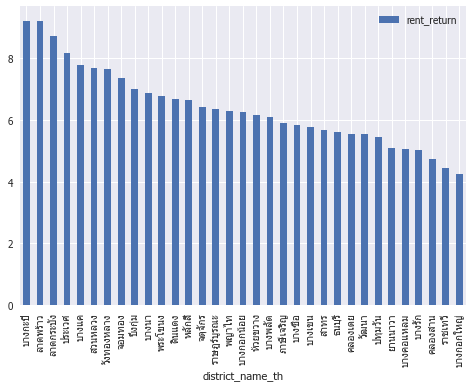

In [116]:
dct_mean[['rent_return']].sort_values(by='rent_return', ascending=False).dropna().plot.bar()

จำนวนน้อยจะแม่นไหม?

<AxesSubplot: xlabel='province_name_th'>

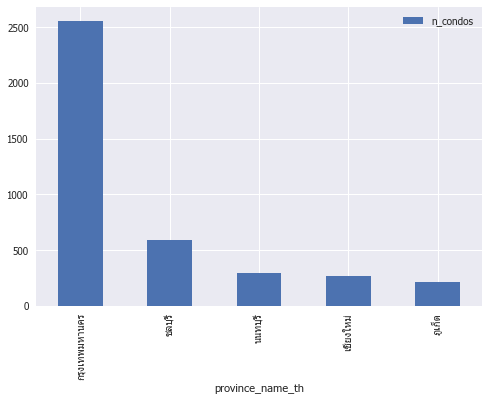

In [117]:
# ให้ดูว่าจำนวนคอนโดใน bkk เยอะมาก
# เล่าว่าน่าสนใจมา analyse
# top 5 most number of condos in Thailand by province
proj_cd.groupby('province_name_th').size().to_frame('n_condos').sort_values(by='n_condos', ascending=False).head().plot.bar()

<AxesSubplot: xlabel='district_name_th'>

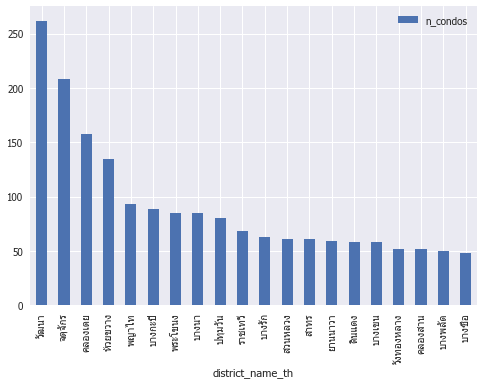

In [118]:
# number of condos in Thailand by distric
dct_count.sort_values(by='n_condos', ascending=False).head(20).plot.bar()

<AxesSubplot: xlabel='district_name_th'>

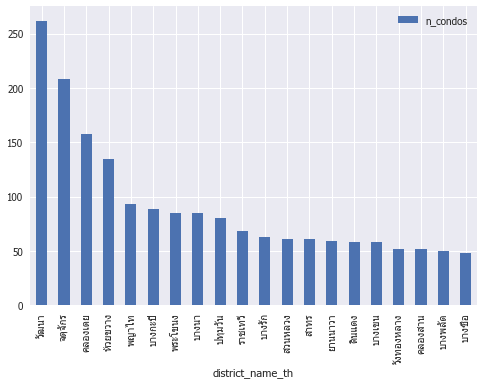

In [119]:
subdct_count.sort_values(by='n_condos', ascending=False).head(20).plot.bar()

<AxesSubplot: title={'center': 'Histogram of Condominium SQM Price'}, ylabel='Frequency'>

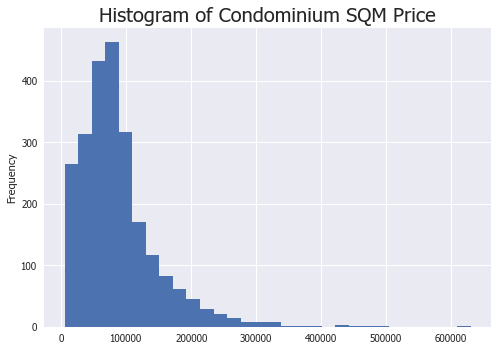

In [120]:
plt.title("Histogram of Condominium SQM Price", fontsize='20')
df_new['pricesqm'].plot.hist(bins=30)

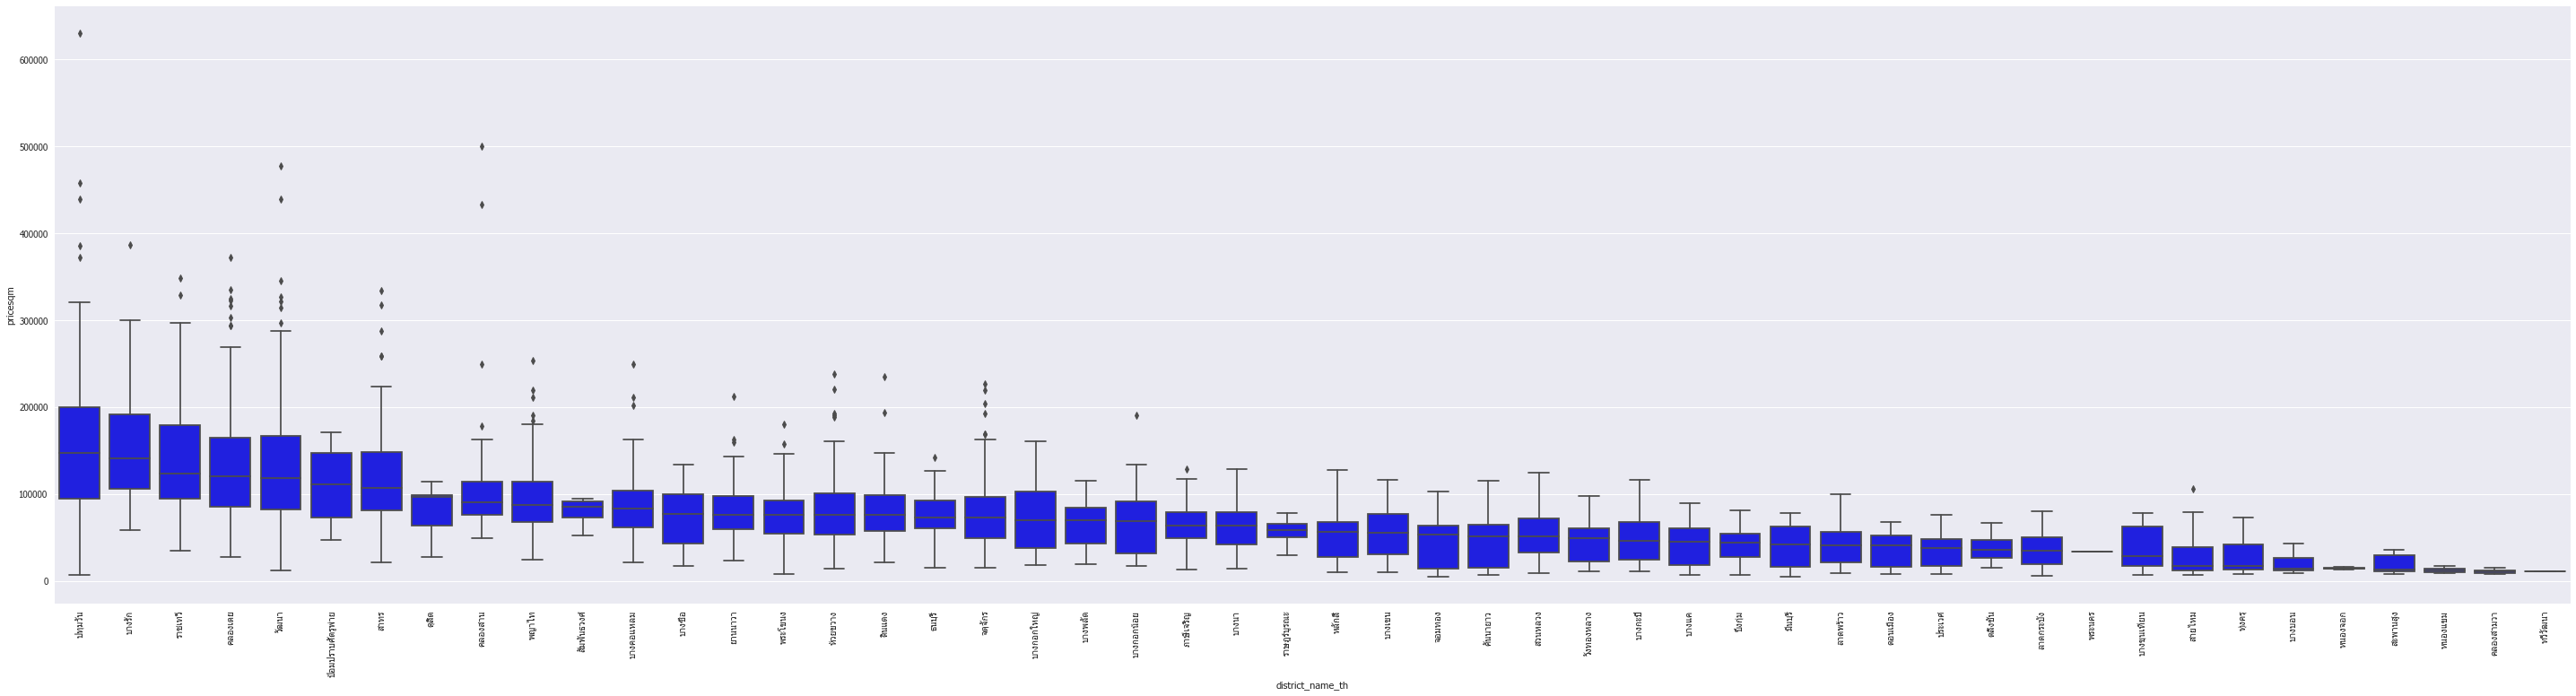

In [121]:
df_new['pricesqm_dct_med'] = df_new.groupby('district_name_th')['pricesqm'].transform('median')
sns.catplot(data=df_new.sort_values(by='pricesqm_dct_med', ascending=False), kind='box', x='district_name_th', y='pricesqm', height=10, aspect=4, color='Blue').set_xticklabels(rotation=90)

<AxesSubplot: xlabel='district_name_th'>

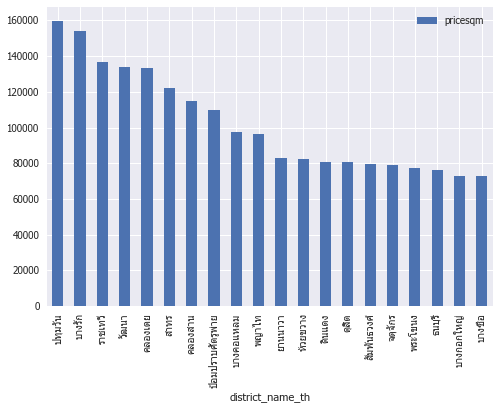

In [122]:
dct_mean[['pricesqm']].sort_values(by='pricesqm', ascending=False).head(20).plot.bar()

<AxesSubplot: xlabel='subdistrict_name_th'>

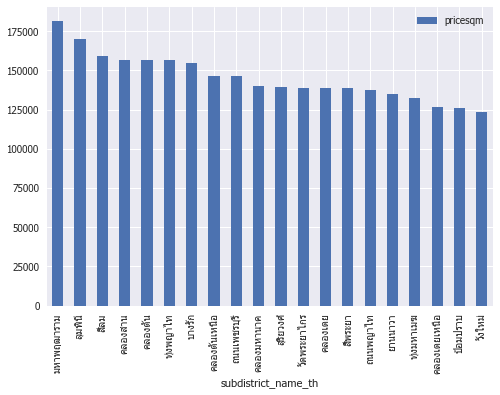

In [123]:
subdct_mean[['pricesqm']].sort_values(by='pricesqm', ascending=False).head(20).plot.bar()

## Map visualization

### Condos Mean SQM Price by Locations

In [124]:
geometry = [Point(xy) for xy in zip(df_new['longitude'], df_new['latitude'])]
gdf = gpd.GeoDataFrame(df_new, geometry=geometry)

In [125]:
url = 'https://raw.githubusercontent.com/apisit/thailand.json/master/thailand.json'
th = gpd.read_file(url)

In [126]:
th.head()

,name,geometry
0,Mae Hong Son,"POLYGON ((98.08593 19.77316, 98.11135 19.77714..."
1,Chumphon,"POLYGON ((99.27258 10.95801, 99.27754 10.95902..."
2,Nakhon Si Thammarat,"POLYGON ((100.34246 7.93878, 100.33778 7.93789..."
3,Phuket,"POLYGON ((98.41863 7.90375, 98.42189 7.90843, ..."
4,Phangnga,"MULTIPOLYGON (((98.53631 8.11514, 98.54054 8.1..."


In [127]:
bkk = th.loc[th['name']=='Bangkok Metropolis']

(100.29711864552405, 100.9541224710602, 13.464382490100142, 14.013123471899993)

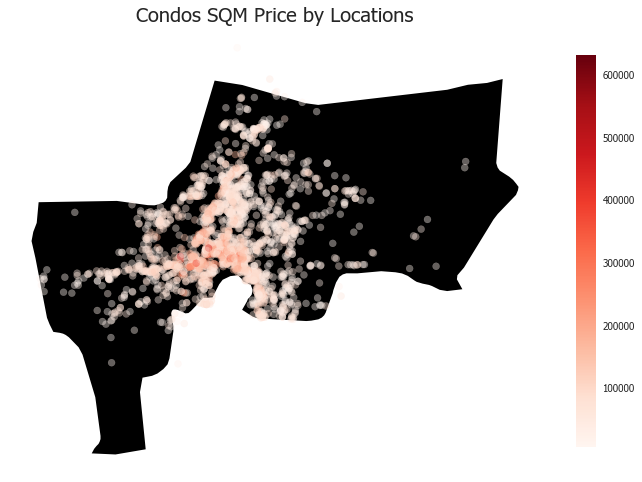

In [128]:
gdf.plot(ax=bkk.plot(figsize=(12,12), color='Black'), marker='o', cmap='Reds', column='pricesqm', alpha=0.4, legend=True, legend_kwds={'shrink': 0.6})
plt.title('Condos SQM Price by Locations', fontsize = 20)
plt.axis('off')

### Number of Condos by Districts

In [129]:
geo = gpd.read_file('district', encoding='cp874')

In [130]:
geo.head()

,OBJECTID,AREA,dcode,dname,dname_e,pcode,pname,num_male,num_female,num_school,num_hos,num_comm,num_temple,num_health,geometry
0,29,11804564.0,1025,เขตบางพลัด,Bang Phlat,10,กรุงเทพมหานคร,45904.0,53249.0,11.0,0.0,46.0,23.0,1.0,"POLYGON ((663924.794 1526162.057, 663895.856 1..."
1,30,16319268.0,1017,เขตห้วยขวาง,Huai Khwang,10,กรุงเทพมหานคร,35884.0,42323.0,3.0,0.0,25.0,3.0,2.0,"POLYGON ((671711.864 1526487.438, 671710.552 1..."
2,31,17075578.0,1045,เขตวังทองหลาง,Wang Thong Lang,10,กรุงเทพมหานคร,52758.0,61990.0,3.0,0.0,19.0,1.0,0.0,"POLYGON ((674358.118 1525633.939, 674369.430 1..."
3,32,51732144.0,1048,เขตทวีวัฒนา,Thawi Watthana,10,กรุงเทพมหานคร,35487.0,40787.0,7.0,0.0,16.0,3.0,1.0,"POLYGON ((650975.092 1526253.298, 651115.593 1..."
4,33,128628048.0,1011,เขตลาดกระบัง,Lat Krabang,10,กรุงเทพมหานคร,78158.0,85159.0,20.0,1.0,63.0,13.0,2.0,"POLYGON ((694058.076 1525667.706, 694060.576 1..."


In [131]:
geo = geo[['geometry','dname', 'dname_e']]
geo['dname'] = geo['dname'].replace(to_replace ='เขต', value = '', regex = True)
geo = pd.merge(geo, dct_count, left_on='dname', right_on=dct_count.index, how='left')
geo.fillna(0, inplace=True)

(640234.846434488, 712844.203087552, 1489630.155587012, 1545825.936422888)

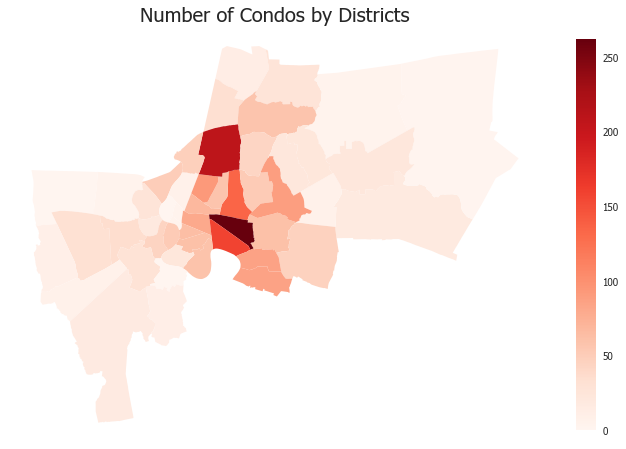

In [132]:
geo.plot(column='n_condos', cmap='Reds', figsize=(12,12), legend=True, legend_kwds={'shrink': 0.6})
plt.title('Number of Condos by Districts', fontsize = 20)
plt.axis('off')

### Condos Mean SQM Price by Districs

In [133]:
geo = pd.merge(geo, dct_mean[['pricesqm']], left_on='dname', right_on=dct_count.index, how='left')

(640234.846434488, 712844.203087552, 1489630.155587012, 1545825.936422888)

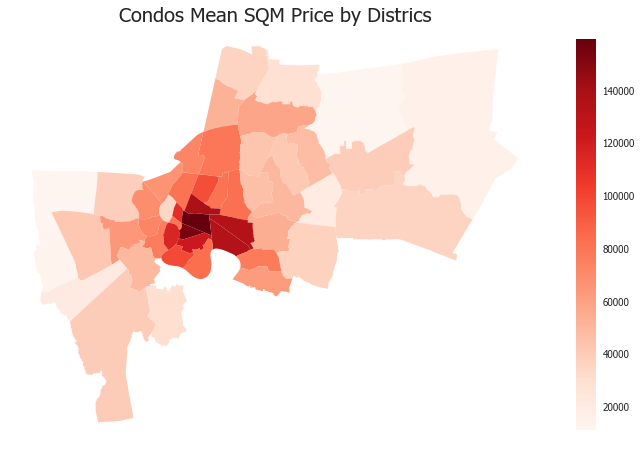

In [134]:
geo.plot(column='pricesqm', cmap='Reds', figsize=(12,12), legend=True, legend_kwds={'shrink': 0.6})
plt.title('Condos Mean SQM Price by Districs', fontsize = 20)
plt.axis('off')

## Location Scores

<AxesSubplot: xlabel='district_name_th'>

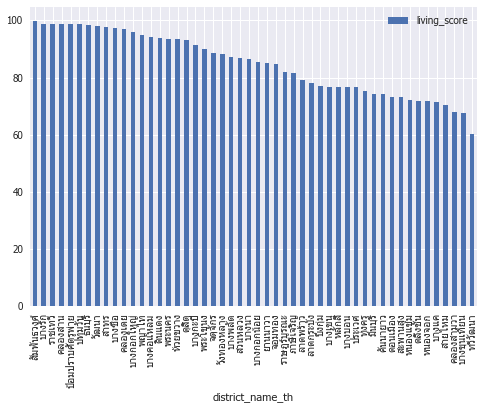

In [137]:
# คะแนน bar
dct_mean[['living_score']].sort_values(by='living_score', ascending=False).plot.bar()

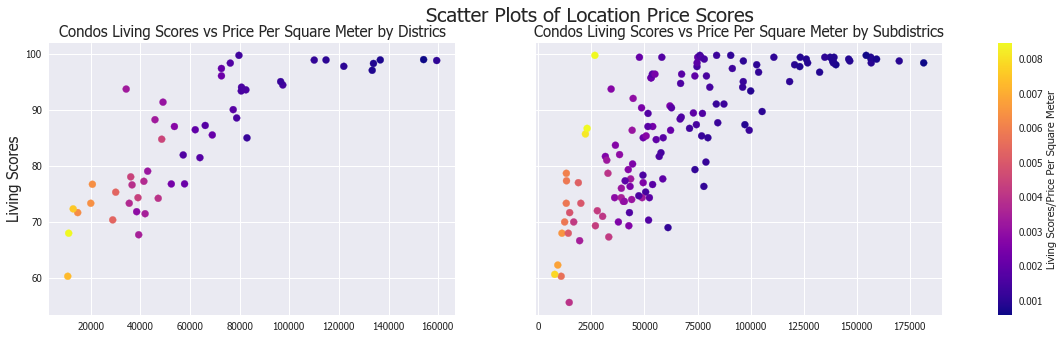

In [289]:
# living score สูงขึ้นตาม condominium sqm price ที่สูงขึ้น แต่เมื่อเทียบสัดส่วน living score ที่ได้ต่อ condominium sqm price พบว่าราคาต่ำจะมีสัดส่วนที่สูงกว่าราคาสูง สรุปได้ว่าทั้งสองค่าไปในทิศทางเดียวกันแต่มีปัจจัยอื่นที่ไม่มีข้อมูลร่วมด้วย
fig, axs = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(20,5))
fig.suptitle('Scatter Plots of Location Price Scores', fontsize=20)

pcm1 = axs[0].scatter(dct_mean['pricesqm'], dct_mean['living_score'], c=dct_mean['livsc_per_pricesqm'], cmap='plasma')
axs[0].set_title('Condos Living Scores vs Price Per Square Meter by Districs', fontsize=15)
axs[0].set_ylabel('Living Scores', fontsize=15)

pcm2 = axs[1].scatter(subdct_mean['pricesqm'], subdct_mean['living_score'], c=subdct_mean['livsc_per_pricesqm'], cmap='plasma')
axs[1].set_title('Condos Living Scores vs Price Per Square Meter by Subdistrics', fontsize=15)
fig.colorbar(pcm2, ax=[axs[0], axs[1]], label = 'Living Scores/Price Per Square Meter')

Text(0.5, 1.0, 'Condos Living Scores vs Price Per Square Meter by Subdistrics')

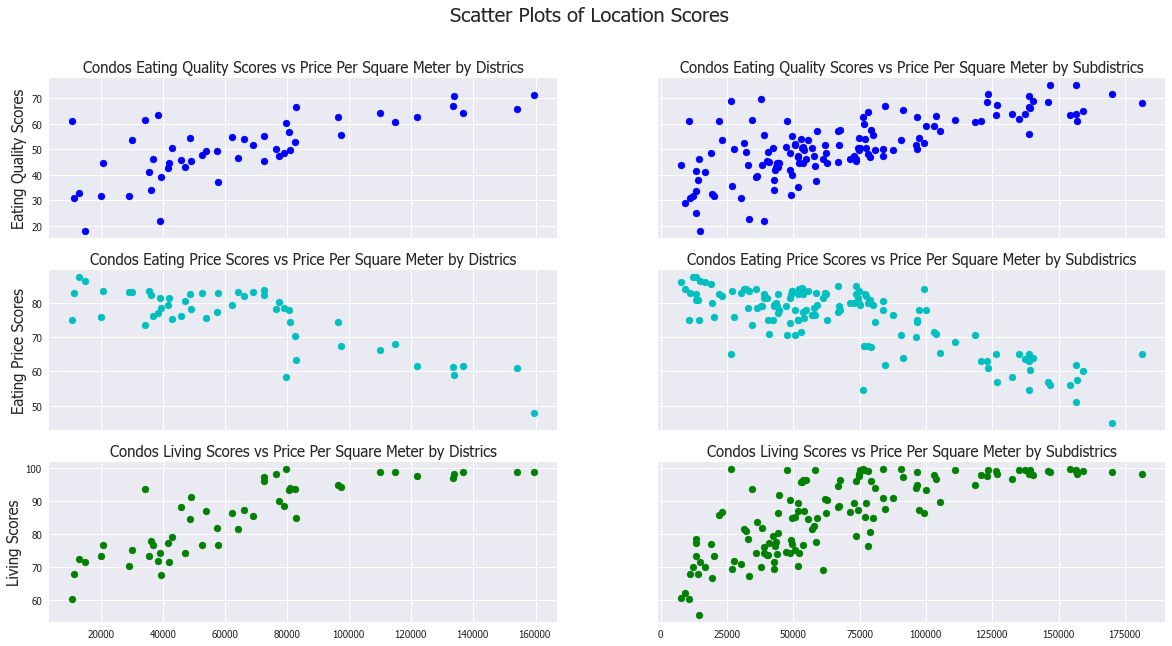

In [287]:
fig, axs = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(20,10))
fig.suptitle('Scatter Plots of Location Scores', fontsize=20)

axs[0,0].scatter(dct_mean['pricesqm'], dct_mean['eating_quality_score'], color='b')
axs[0,0].set_title('Condos Eating Quality Scores vs Price Per Square Meter by Districs', fontsize=15)
axs[0,0].set_ylabel('Eating Quality Scores', fontsize=15)

axs[0,1].scatter(subdct_mean['pricesqm'], subdct_mean['eating_quality_score'], color='b')
axs[0,1].set_title('Condos Eating Quality Scores vs Price Per Square Meter by Subdistrics', fontsize=15)

axs[1,0].scatter(dct_mean['pricesqm'], dct_mean['eating_price_score'], color='c')
axs[1,0].set_title('Condos Eating Price Scores vs Price Per Square Meter by Districs', fontsize=15)
axs[1,0].set_ylabel('Eating Price Scores', fontsize=15)

axs[1,1].scatter(subdct_mean['pricesqm'], subdct_mean['eating_price_score'], color='c')
axs[1,1].set_title('Condos Eating Price Scores vs Price Per Square Meter by Subdistrics', fontsize=15)

axs[2,0].scatter(dct_mean['pricesqm'], dct_mean['living_score'], color='g')
axs[2,0].set_title('Condos Living Scores vs Price Per Square Meter by Districs', fontsize=15)
axs[2,0].set_ylabel('Living Scores', fontsize=15)

axs[2,1].scatter(subdct_mean['pricesqm'], subdct_mean['living_score'], color='g')
axs[2,1].set_title('Condos Living Scores vs Price Per Square Meter by Subdistrics', fontsize=15)